In [193]:
] add QuadGK

In [194]:
using Agents
using Clustering
using Colors
using DataFrames
using Distributions
using GraphPlot
using LightGraphs
using Plots
using QuadGK


# Expectation of Campus Drinking Model

For this work, we use the simplified model of a social drinker.

### Healthy Drinker:

$$ \frac{ds}{dt} = s_{\text{slope}}s + m(t) $$

$$ \frac{dp}{dt}  = \gamma[-p + \sigma\,(a s) + b] $$

$$s(t_i) \leftarrow s(t_i) - s_{drink} \quad \text{if } t_i \in e $$

where $s$ represents an individuals propensity to be social, $p$ represents probability of drinking (if alcohol is encountered), $m(t)$ is given and represents mood, and $e$ is a given set of encounter times. Together these equations model an individual's drinking behavior. The different variables evolve as follows:

**Propensisty To Drink Socially ($s$):**

This variable represents a person's desire to drink socially. It increases when they are in a good mood and decreases when they are in a bad mood. Upon drinking, $s$ immidiately makes a discontinuous jump down. This models an individuals ability to regulate their own social drinking. The size of this instantanious decrease $s_{drink}$ is a parameter that can be tuned to match different kinds of behavior. A large $s_{drink}$ might model an individual who doesn't like to drink a lot in quick succession. in the period following drinking, if the individual does not drink again, their desire to drink socially will return to normal levels. The speed at which it returns to normal levels is governed by $s_{slope}$, which is also a parameter that can be tuned.

**Probability of Drinking ($p$):**

The variable $p$ represents a person's probability of drinking at a given time. It's evolution depends on the evolution of $s$. The trajectory of $p$ usually looks like a transformed version of $s$ that stays in the interval (0,1). The responsiveness of $p$ to $s$ is governed by the parameter $\gamma$. This parameter controls the delay, or how quickly $p$ changes in response to changes in $s$. For large $\gamma$, every change in $s$ will be reflected in the trajectory of $p$. For small $\gamma$, small scale oscillations in $s$ will not affect $p$, and $p$ will tend to illustrate the longer term trends present in the evolution of $s$. The parameter $a$ controls the impact of $s$ on $p$ and is usually set to $a=10$. The parameter $b$ controls the probability of drinking when an individual is in a neutral mood.

**Drinking Opportunities ($e$):** 

In this model, the modeler supplies two pieces a priori, a function describing an individual's mood at a given time, $m(t)$, and a set of times that an individual will encounter alcohol, $e$. Before an encounter time is reached, $s$ and $p$ evolve according to differential equation outlined above and respond to the individual's mood. When an encounter time $t_i \in e$ is reached, a draw is taken from a bernoulli random variable with probability of success equal to $p(t_i)$. (This is essentially a coin that lands on heads with probability $p(t_i)$.)

If the random draw is equal to one, the model records that a drink was taken at time $t_i$, and decreases the current value of $s$ by $s_{drink}$.  If the random draw is zero, nothing changes.
Afterwards, the model continues to evolve according to the differential equation until the next drinking opportunity.

### Coupling Multiple Individuals

To couple together the drinking of multiple people, we use a simple rule. Each time I drink, my neighbors in the social network are given an opportunity to drink at the next timestep. This rests on the idea that if my friends go out and drink, I am likely to get invited to go with them. We implement this as follows. If person $i$ drinks at time $t$, and has neigbors $j_1, ..., j_m$, then we update the set of event $e_{j_k}$ times belonging to each neighbor to include the time $t + \delta t$ where $\delta t$ is the model timestep.

# Implementation

### ODE Solver (RK4)

In [2]:
"""
    rk4_step(f::F, y::T, t::T, dt::T; params::Array{T, 1}=[]) -> dy

Returns the fourth order runge-kutta approximation of the change in `y` over the 
timestep `dt`
        
### Parameters
1. `f` (callable) accepts `y`, `t` and all of the parameters in `params`
2. `y` current system state
3. `t` time value
4. `dt` timestep size
5. `params` parameters for `f`
        
### Returns
`dy` approximation of the change in `y` over the timestep `dt`
"""
function rk4_step(f::F, y::T, t::T, dt::T; params=[]) where {F, T <: AbstractFloat}
    two = convert(T, 2)
    dy1 = f(y, t, params...) * dt
    dy2 = f(y + dy1 / two, t + dt / two, params...) * dt
    dy3 = f(y + dy2 / two, t + dt / two, params...) * dt
    dy4 = f(y + dy3, t + dt, params...) * dt
    dy = convert(T, 1/6) * (dy1 + dy2 * two + dy3 * two + dy4)
    return dy
end

function rk4_step(f::F, y::Array{T,1}, t::T, dt::T; params=[]) where {F, T <: AbstractFloat}
    two = convert(T, 2)
    dy1 = f(y, t, params...) .* dt
    dy2 = f(y .+ dy1 ./ two, t .+ dt ./ two, params...) * dt
    dy3 = f(y .+ dy2 ./ two, t .+ dt ./ two, params...) * dt
    dy4 = f(y .+ dy3, t .+ dt, params...) * dt
    dy = convert(T, 1/6) .* (dy1 .+ dy2 .* two .+ dy3 .* two .+ dy4)
    return dy
end

rk4_step (generic function with 2 methods)

### ODE Definitions

In [3]:
""" Sigmoid function """
σ(x::T) where T = 1. / (1. + exp(-x)) 
""" Derivative of social drinking propensity """
dsdt(s::T, t::T, s_slope::T, s_drink::T, m::F) where {F, T <: AbstractFloat} = s_slope * s + m(t)
""" Deriviative of drinking probability """
dpdt(p::T, t::T, a::T, b::T, γ::T, s::T) where T = γ * (-p + σ(a * s) + b)
""" Return true if current timestep contains an event time """
event(events::Array{T, 1}, t::T, dt::T) where T = any((events .< t + dt) .& (events .>= t))


event

### Mood and Event Time Generators

In [4]:
""" 
    random_event_times(end_time::T; start_time:T=0.0; dist::Distribution=Exponential, distparams=[1.0]) where T=Float64 ->

Returns an array of event times where t_i - t_(i-1) is distributed according to
`dist`.
    
**Parameters**

1. `end_time` maximum length of time to simulate. All returned event times
will be strictly less than this value
2. `start_time` Initial time. Defaults to zero. All events will be 
strictly between start_time and max_time
3. `scale` Parameter for the exponential distribution
**Returns**

`event_times` An array of event times with values between start_time and end_time. 
The distance between events is exponentially distributed with parameter `scale`.
"""
function random_event_times(
        end_time::Float64; 
        start_time::Float64=0.0,
        dist=Exponential, 
        distparams::Array{Float64, 1}=[1.0]
)
    event_times::Array{Float64, 1} = []
    current_event = start_time
    d = dist(distparams...)
    while current_event < end_time
        next_event = current_event + rand(d)
        push!(event_times, next_event)
        current_event = next_event
    end
    return event_times
end

"""
    random_phase_sin(freq) -> func

Creates a sin function with frequency `freq` and random phase.
"""
function random_phase_sin(freq::Float64)
    a = rand()
    func = t::Float64 -> sin(2π*freq*(t - a))
    return func
end

function uniform_sin()
    func = t::Float64 -> sin(2π*t)
    return func
end

function regular_events(
        end_time::Float64;
        start_time::Float64=0.0, 
        period=1.0
)
    dist = x -> [period]
    return random_event_times(end_time, start_time=start_time, dist=dist)
end

regular_events (generic function with 1 method)

### Social Drinker Definiton and State Update

In [72]:
mutable struct SocialDrinker{F, T} <: AbstractAgent
    id::Int
    pos::Int
    s::T
    p::T
    d::T
    e::T
    m::F
    s_slope::T
    s_drink::T
    γ::T
    a::T
    b::T
    events::Array{T, 1}
end

function Base.show(io::IO, sd::SocialDrinker)
    descr = "SocialDrinker"
    print(io, descr)
end

function Base.show(io::IO, a::Array{SocialDrinker, N}) where N
    descr = "Array{SocialDrinker, $N}"
    print(io, descr)
end


""" 
    agent_step!(sd::SocialDrinker, model::AgentBasedModel)

The social drinker acts during a timestep. First, social drinking propensity 
and drinking probability are evolved according to their respective ODE, then
if the agent has a drinking opportunity during this timestep, they drink with
probability `sd.p`.
"""

function agent_step!(sd::SocialDrinker, model::AgentBasedModel)
    # Agent did not drink yet during this timestep
    sd.d = 0.0
    sd.e = 0.0
    # Update internal state
    sd.s += rk4_step(dsdt, sd.s, model.t, model.dt, params=[sd.s_slope, sd.s_drink, sd.m])
    sd.p += rk4_step(dpdt, sd.p, model.t, model.dt, params=[sd.a, sd.b, sd.γ, sd.s])
    event(sd.events, model.t, model.dt) && event_step!(sd)    
end

""" Social drinker response to drinking event """
function event_step!(sd::SocialDrinker)
    sd.e = 1.0
    if rand() < sd.p
        sd.d = 1.0
        sd.s += sd.s_drink
    end
end

event_step!

In [6]:
newdrinker(id, maxdays; freq=1) = 
    SocialDrinker(id, 0, 0.0, 0.0, 0.0, 0.0, random_phase_sin(1.0), -1., -.5, 3.0, 10.0, 0.0, random_event_times(maxdays))

uniformdrinker(id, maxdays; freq=1) =
    SocialDrinker(id, 0, 0.0, 0.0, 0.0, 0.0, uniform_sin(), -1., -.5, 3.0, 10.0, 0.0, regular_events(maxdays))


uniformdrinker (generic function with 1 method)

### Model Initializer

In [7]:
function nightlife(; npeople=2, adj=[0. 1.; 1. 0.], starttime=0.0, maxtime=30.0, dt=.001)
    space = GraphSpace(Graph(1)) # Dummy space to place agents
    properties = Dict(:t => starttime, :dt => dt, :adj => adj, :npeople => npeople)
    atype = SocialDrinker{typeof(random_phase_sin(1.0)), Float64}
    model = AgentBasedModel(atype, space; properties)
    for i in 1:npeople
        add_agent!(newdrinker(i, maxtime), model)
    end
    return model
end

function uniformlife(; npeople=1, adj=[0], starttime=0.0, maxtime=30.0, dt=.001)
    space = GraphSpace(Graph(1)) # Dummy space to place agents
    properties = Dict(:t => starttime, :dt => dt, :adj => adj, :npeople => npeople)
    atype = SocialDrinker{typeof(uniform_sin()), Float64}
    model = AgentBasedModel(atype, space; properties)
    for i in 1:npeople
        add_agent!(uniformdrinker(i, maxtime), model)
    end
    return model
end

uniformlife (generic function with 1 method)

### Coupling Rule

People are coupled in the model in the following way: If I drink, each of my neighbors in the supplied social network is given an **opportunity** to drink at the next timestep. That is, if I drink at time $t$, we add $t+dt$ to each neighbor's set of drinking opportunities $e$.

In [8]:
function model_step!(model)
    drinks = [model[i].d for i in 1:model.npeople]
    drink_influence = model.adj * drinks .> 0.0
    for id in findall(drink_influence)
        push!(model[id].events, model.t + model.dt)
    end
    model.t += model.dt
end

model_step! (generic function with 1 method)

### Plotting and Data Measurement

In [47]:
function plot_agent(i::Int, adf::DataFrame, mdf::DataFrame)
    ai = filter(:id => ==(i), adf)
    sp = plot(mdf.t, ai.s, color=:darkblue, linewidth=3, label="Social Propensity", legend=(.85, .25))
    maxtime = round(mdf.t[end])
    title!("$maxtime Days of Drinking Behavior")
    pp = plot(mdf.t, ai.p, color=:red, alpha=.7, linewidth=3, label="Probability of Drinking", legend=(.85, .8))
    ylims!(-.1, 1.1)
    yticks!([0, 1])
    dp = plot(mdf.t, ai.e, color=:orange, alpha=.7, linewidth=3, label="Drinking opportunities")
    plot!(mdf.t, ai.d, color=:green, linewidth=3, label="Drinking Behavior", legend=(.85, .8))
    ylims!(-.2, 1.2)
    yticks!([0, 1], ["Abstain", "Drink"])
    p = plot(sp, pp, dp, layout=(3, 1), size=(1000,375))  
    return p
end

function drinking_stats(i::Int, adf::DataFrame, mdf::DataFrame)
    aidf = filter(:id => ==(i), adf)
    totdrinks = sum(aidf.d)
    totenc = sum(aidf.e)
    meanprob = mean(aidf.p)
    return totdrinks, totenc, meanprob
end

function raster_plot(adf::DataFrame; starttime=0.0, dt=0.001, opportunites=false)
    drinks = filter(:d => ==(1.0), adf)
    dtimes = drinks.step .* dt
    p = plot(dtimes, drinks.id, seriestype=:scatter, alpha=0.7, color=:green, label="Drinks")
    if opportunites
        opps = filter(:e => ==(1.0), adf)
        optimes = opps.step .* dt
        plot!(opptimes, opps.id)
    end
    ylabel!("Person Id")
    xlabel!("Time")
    return p
end

raster_plot (generic function with 1 method)

# Plot a non-uniform person

In [52]:
adata = [:s, :p, :d, :e]
mdata = [:t]
maxdays = 10.0
dt = .001
n = floor(Int, maxdays / dt)
single_adj = reshape([0.0], 1, 1)
single_nl = nightlife(maxtime=maxdays, npeople=1, adj=single_adj)
single_adf, single_mdf = run!(single_nl, agent_step!, model_step!, n; adata, mdata);

In [53]:
png(plot_agent(1, single_adf, single_mdf), "nonuniform_person.png")

![nonuniform_person.png](nonuniform_person.png)

# Plot a uniform person

In [68]:
single_ul = uniformlife(maxtime=maxdays, npeople=1, adj=single_adj)
single_adf, single_mdf = run!(single_ul, agent_step!, model_step!, n; adata, mdata);

In [69]:
png(plot_agent(1, single_adf, single_mdf), "../Latex/uniform_person.png")

![uniform_person.png](../../Latex/DrinkingModel/uniform_person.png)

In [10]:
function expected_p(; reps=300)
    adata = [:p]
    mdata = [:t]
    maxdays = 10.0
    dt = .001
    n = floor(Int, maxdays / dt)
    single_adj = reshape([0.0], 1, 1)
    probs = zeros(n+1, reps)
    t = zeros(n+1)
    for i in 1:reps
        single_nl = uniformlife(maxtime=maxdays, npeople=1, adj=single_adj)
        single_adf, single_mdf = run!(single_nl, agent_step!, model_step!, n; adata, mdata);
        probs[:, i:i] = single_adf[!, :p]
        t[:] = single_mdf[!, :t]
    end
    return t, probs
end
    

expected_p (generic function with 1 method)

In [11]:
t, P = expected_p(reps=1000)
mean_p = mean(P, dims=2);

In [67]:
p = plot(
    size=(1400, 600), 
    legendfontsize=14, 
    titlefontsize=18, 
    legend=(.85, .97)
)
for i in 1:size(P, 2)
    plot!(p, t, P[:, i], color=:red, linewidth=2, alpha=.2, label=false)
end
plot!(t[1:2], P[1:2,1], color=:red, label="Realization of p(t)")
plot!(t[1:2], P[1:2,1], color=:gray, label="E[p(t)]")
xticks!(p, 0:1:10)
plot!(p, t, mean_p, color=:gray, linewidth=5, label=false)
title!("Expected Probability of Drinking")
png(p, "../Latex/expected_p.png")

![expectedd_p](../../Latex/DrinkingModel/expected_p.png)

# A Simpler Model

One variable, probability of drinking $p$, a mood function $m(t)$ and a set of drinking opportunities $e$.

$$ \frac{dp}{dt} = a\big(-p(t) + m(t)\big) $$

The if $p(t_0) = p_0$, solution to this equation is 

$$p(x) = e^{-at} \int_{t_0}^t -ae^{as}m(s)ds + p_0 e^{-a(t-t_0)}$$

We add in a probabalistic drinking just like before. Drinking reduces the probability of drinking.

$$ p(t_i) \leftarrow p(t_i) - b\text{ with probability } p(t_i) \text{ if } t_i \in e $$

Where b is a fixed parameter representing the amount that probability of drinking increases in response to a drinking event. To keep $0 \leq p \leq 1$ we require $0 \leq m(t) \leq 1$ for all $t$ and in the case that $p(t_i) - b < 0$, we set $p(t_i) \leftarrow 0$ to avoid negative probabilities. 

In [170]:
mutable struct SimpleDrinker{F, T} <: AbstractAgent
    id::Int
    pos::Int
    p::T
    d::T
    e::T
    m::F
    a::T
    b::T
    events::Array{T, 1}
end

function Base.show(io::IO, sd::SocialDrinker)
    descr = "SimpleDrinker"
    print(io, descr)
end

function Base.show(io::IO, a::Array{SocialDrinker, N}) where N
    descr = "Array{SimpleDrinker, $N}"
    print(io, descr)
end


dsimplep_dt(p, t, a, m) = a*(-p + m(t))

function simple_sin()
    func = t::Float64 -> sin(2*2^.5*π*(t-.25))/2 + .5
    return func
end

function constant(c::Float64=.5)
    func = t::Float64 -> c
    return func
end

""" 
    agent_step!(sd::SimpleDrinker, model::AgentBasedModel)

The simplified, one variable social drinker model state update. Runge-Kutta 
and probabalistic state update
"""

function agent_step!(sd::SimpleDrinker, model::AgentBasedModel)
    # Agent did not drink yet during this timestep
    sd.d = 0.0
    sd.e = 0.0
    # Update internal state
    sd.p += rk4_step(dsimplep_dt, sd.p, model.t, model.dt, params=[sd.a, sd.m])
    event(sd.events, model.t, model.dt) && event_step!(sd)    
end

""" Social drinker response to drinking event """
function event_step!(sd::SimpleDrinker)
    sd.e = 1.0
    if rand() < sd.p
        sd.d = 1.0
        sd.p += sd.b
        if sd.p < 0.0
            sd.p = 0.0
        end
    end
end

simpledrinker(i::Int, maxtime, moodmaker) = 
    SimpleDrinker(i, 1, 0.0, 0.0, 0.0, moodmaker(), 1.2, -.2, regular_events(maxdays))

simpledrinker (generic function with 2 methods)

In [171]:
function simplelife(; moodmaker=simple_sin, npeople=1, adj=reshape([0.0], 1, 1), starttime=0.0, maxtime=30.0, dt=.001)
    space = GraphSpace(Graph(1)) # Dummy space to place agents
    properties = Dict(:t => starttime, :dt => dt, :adj => adj, :npeople => npeople)
    atype = SimpleDrinker{typeof(moodmaker()), Float64}
    model = AgentBasedModel(atype, space; properties)
    for i in 1:npeople
        add_agent!(simpledrinker(i, maxtime, moodmaker), model)
    end
    return model
end

simplelife (generic function with 1 method)

In [172]:
sl = simplelife(moodmaker=constant)

AgentBasedModel with 1 agents of type SimpleDrinker
 space: GraphSpace with 1 positions and 0 edges
 scheduler: fastest
 properties: Dict{Symbol, Any}(:npeople => 1, :adj => [0.0], :dt => 0.001, :t => 0.0)

In [180]:
function simple_expected_p(; 
        reps=300,
        moodmaker=simple_sin
)
    adata = [:p]
    mdata = [:t]
    maxdays = 10.0
    dt = .001
    n = floor(Int, maxdays / dt)
    single_adj = reshape([0.0], 1, 1)
    probs = zeros(n+1, reps)
    t = zeros(n+1)
    for i in 1:reps
        sl = simplelife(moodmaker=moodmaker, maxtime=maxdays, npeople=1, adj=single_adj)
        simple_adf, simple_mdf = run!(sl, agent_step!, model_step!, n; adata, mdata);
        probs[:, i:i] = simple_adf[!, :p]
        t[:] = simple_mdf[!, :t]
    end
    return t, probs
end

simple_expected_p (generic function with 1 method)

In [190]:
simple_t, simple_P = simple_expected_p(reps=300, moodmaker=constant)
mean_simple_p = mean(simple_P, dims=2);

In [192]:
sp = plot(
    size=(1400, 600), 
    legendfontsize=14, 
    titlefontsize=18, 
    legend=(.85, .15)
)
for i in 1:size(simple_P, 2)
    plot!(sp, simple_t, simple_P[:, i], color=:darkgreen, linewidth=2, alpha=.2, label=false)
end
plot!(simple_t[1:2], simple_P[1:2,1], color=:darkgreen, label="Realization of p(t)")
plot!(simple_t[1:2], simple_P[1:2,1], color=:black, label="E[p(t)]")
xticks!(sp, 0:1:10)
plot!(sp, simple_t, mean_simple_p, color=:black, linewidth=5, label=false)
title!("Simple Model Expected Probability of Drinking")
png(sp, "../Latex/simple_expected_p.png")

![simple_expected_p.png](../../Latex/DrinkingModel/simple_expected_p.png)

In [259]:
simple_t, simple_P_sin = simple_expected_p(reps=300, moodmaker=simple_sin)
mean_simple_p_sin = mean(simple_P_sin, dims=2);

In [260]:
sp = plot(
    size=(1400, 600), 
    legendfontsize=14, 
    titlefontsize=18, 
    legend=(.85, .15)
)
for i in 1:size(simple_P_sin, 2)
    plot!(sp, simple_t, simple_P_sin[:, i], color=:lightblue, linewidth=2, alpha=.2, label=false)
end
plot!(simple_t[1:2], simple_P_sin[1:2,1], color=:lightblue, label="Realization of p(t)")
plot!(simple_t[1:2], simple_P_sin[1:2,1], color=:black, label="E[p(t)]")
xticks!(sp, 0:1:10)
plot!(sp, simple_t, mean_simple_p_sin, color=:black, linewidth=5, label=false)
title!("Simple Model Expected Probability of Drinking")
png(sp, "../Latex/simple_expected_p_sin.png")

![../Latex/simple_expected_p_sin.png](../../Latex/DrinkingModel/simple_expected_p_sin.png)

In [244]:
struct ExpectESLS{T, F}
    integrand::F
    E::Array{T, 1}
    I::Array{T, 1}
    a::T
    α::T
    β::T
    c::T
    t0::T
    x0::T
end

function Base.show(io::IO, exp_esls::ExpectESLS)
    descr = "ExpectESLS"
    print(io, descr)
end

function ExpectESLS(
    m::F, 
    E::Array{T, 1}, 
    a::T, 
    α::T, 
    β::T, 
    c::T, 
    t0::T,
    x0::T
) where {T, F}
    integrand(s) = -a*exp(a*s) * m(s)
    N = length(E)
    I = zeros(N)
    for i in 1:N
        int_end = E[i]
        int_start = i == 1 ? t0 : E[i-1]
       I[i] = exp(-a*int_end)*quadgk(integrand, int_start, int_end, rtol=1e-10)[1]
    end
    return ExpectESLS(integrand, E, I, a, α, β, c, t0, x0)
end

function find_interval(t::T, E::Array{T, 1}) where T
    if t < E[1]
        return 1
    end
    for (i, ti) in enumerate(E)
        if t < ti
            return i
        end
    end
    return length(E)
end
    
function (exp_esls::ExpectESLS)(t)
    n = find_interval(t, exp_esls.E)
    a = exp_esls.a
    start = n == 1 ? exp_esls.x0 : E[n-1]
    expectation = exp(-a*t)*quadgk(exp_esls.integrand, start, t, rtol=1e-10)[1]
    w = exp_esls.c * exp_esls.α + 1
    v = exp_esls.c * exp_esls.β / w
    for k in 1:(n-1)
        expectation += w^(n-k)*(v + exp_esls.I[k])*exp(-a*(t - E[k]))
    end
    expectation += w^(n-1) * exp_esls.x0 * exp(-a*(t - exp_esls.t0))
    return expectation
end

# Constant System

In [274]:
maxdays = 10.
a = 1.2
m = x -> -.5
E = regular_events(maxdays)
α = 1.
β = 0.
c = -0.2
t0 = 0.
x0 = 0.

exp_esls = ExpectESLS(m, E, a, α, β, c, t0, x0)

ExpectESLS

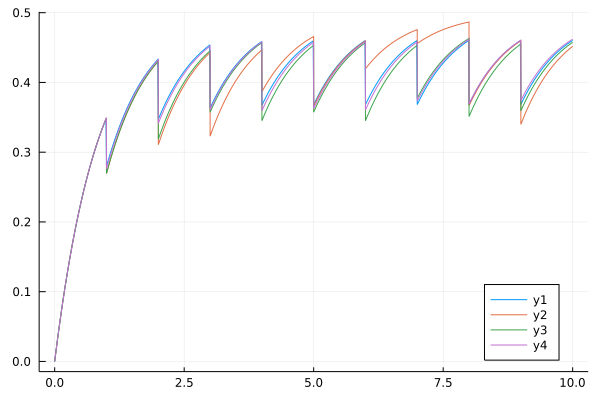

In [282]:
t = 0:.01:10.
expp = plot(t, exp_esls.(t), lw=1, legend=(.9, .2))
plot!(expp, simple_t, mean(simple_P[:, 1:10], dims=2))
plot!(expp, simple_t, mean(simple_P[:, 1:50], dims=2))
plot!(expp, simple_t, mean(simple_P[:, 1:300], dims=2))


In [285]:
maxdays = 10.
m = t::Float64 -> -1*(sin(2*2^.5*π*(t-.25))/2 + .5)
E = regular_events(maxdays)
a = 1.2
α = 1.
β = 0.
c = -0.2
t0 = 0.
x0 = 0.

exp_esls_sin = ExpectESLS(m, E, a, α, β, c, t0, x0)

ExpectESLS

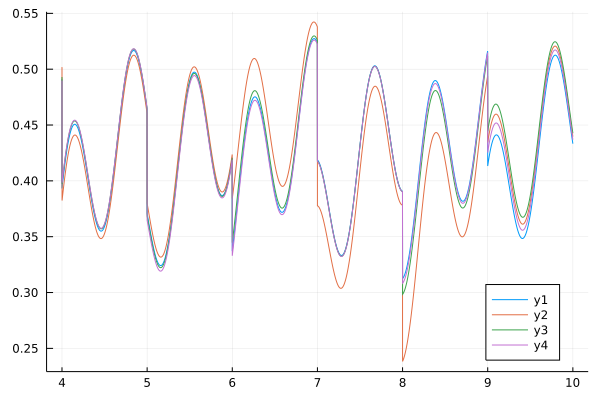

In [292]:
t = 0:.001:10.
sub = 4000:10001
expp_sin = plot(t[sub], exp_esls_sin.(t)[sub], legend=(.9, .2))
plot!(expp_sin, simple_t[sub], mean(simple_P_sin[:, 1:10], dims=2)[sub])
plot!(expp_sin, simple_t[sub], mean(simple_P_sin[:, 1:50], dims=2)[sub])
plot!(expp_sin, simple_t[sub], mean(simple_P_sin[:, 1:300], dims=2)[sub])

In [295]:
sp = plot(
    size=(1400, 600), 
    legendfontsize=14, 
    titlefontsize=18, 
    legend=(.85, .15)
)
for i in 1:size(simple_P_sin, 2)
    plot!(sp, simple_t, simple_P_sin[:, i], color=:lightblue, linewidth=2, alpha=.2, label=false)
end
plot!(simple_t[1:2], simple_P_sin[1:2,1], color=:lightblue, label="Realization of x(t)")
plot!(simple_t[1:2], simple_P_sin[1:2,1], color=:red, label="Analytic E[x(t)]")
plot!(simple_t[1:2], simple_P_sin[1:2,1], color=:gray, label="Numeric E[x(t)]")

xticks!(sp, 0:1:10)
plot!(sp, simple_t, mean_simple_p_sin, color=:gray, alpha=0.8, linewidth=5, label=false)
plot!(sp, simple_t, exp_esls_sin.(simple_t), color=:red, alpha=0.8, linewidth=5, label=false)
title!("Comparing Analytic and Numeric Expectation")
png(sp, "../Latex/analytic_expected_p_sin.png")

![../Latex/analytic_expected_p_sin.png](../../Latex/DrinkingModel/analytic_expected_p_sin.png)